![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 16 - GAN </center>
### <center> Conditional GAN </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/16_GAN/MainCGAN.ipynb)

In [1]:
#-- Wide screen :
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):
    !pip install torchinfo

In [4]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import torch
import torch.nn               as nn
import torch.optim            as optim
import torchvision.transforms as transforms
import torchinfo

torch.backends.cudnn.benchmark = True

#### Load MNIST data:

In [5]:
import torchvision.transforms as transforms
import torchvision

dataPath   = r'../../data/'
oTransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
oTrainSet  = torchvision.datasets.MNIST(root=dataPath, train=True, transform=oTransform, download=True)

In [6]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True, batch_size=batchSize, num_workers=2, persistent_workers=True, drop_last=True)

mX,       vY = next(iter(oTrainDL))
mX.shape, vY.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

#### CGAN:
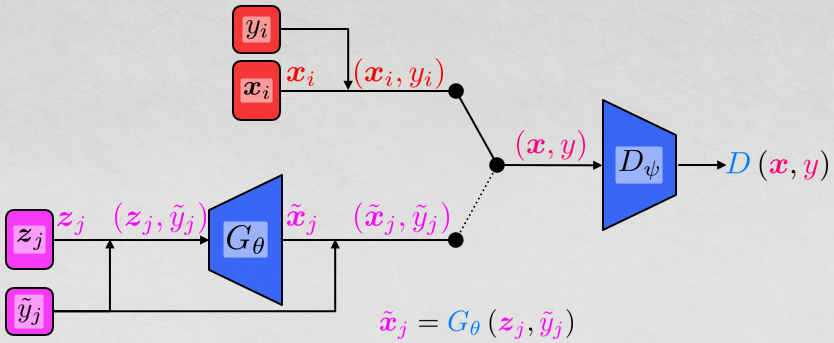

#### GAN Generator:

In [7]:
from DeepLearningFramework.Layers import Reshape

class Generator(nn.Module):
    def __init__(self, D):
        super().__init__()
        
        self.D          = D
        self.oEmbedding = nn.Embedding(10, 4)
        self.oGen = nn.Sequential(
            nn.Identity(),
            nn.Linear(D+4, 64*7*7, bias=False), nn.Unflatten(1, (64, 7, 7)),     nn.BatchNorm2d(64), nn.ReLU(),

            nn.Upsample(scale_factor=2), nn.Conv2d(64, 32, 3, 2, 1, bias=False), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.Conv2d(32, 16, 3, 1, 1, bias=False), nn.BatchNorm2d(16), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.Conv2d(16, 8,  3, 1, 1, bias=False), nn.BatchNorm2d(8 ), nn.ReLU(),
                                         nn.Conv2d(8,  1,  3, 1, 1, bias=False),                     nn.Tanh(),
        )
        
    def forward(self, mZ, vY):
        mY    = self.oEmbedding(vY)
        mZY   = torch.cat([mZ, mY], dim=1)
        mHatX = self.oGen(mZY)
            
        return mHatX

#=============================================================#
#=============================================================#
D  = 16
torchinfo.summary(Generator(D), [(128, D), (128,)], dtypes=[torch.float, torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                --                        --
├─Embedding: 1-1                         [128, 4]                  40
├─Sequential: 1-2                        [128, 1, 28, 28]          --
│    └─Identity: 2-1                     [128, 20]                 --
│    └─Linear: 2-2                       [128, 3136]               62,720
│    └─Unflatten: 2-3                    [128, 64, 7, 7]           --
│    └─BatchNorm2d: 2-4                  [128, 64, 7, 7]           128
│    └─ReLU: 2-5                         [128, 64, 7, 7]           --
│    └─Upsample: 2-6                     [128, 64, 14, 14]         --
│    └─Conv2d: 2-7                       [128, 32, 7, 7]           18,432
│    └─BatchNorm2d: 2-8                  [128, 32, 7, 7]           64
│    └─ReLU: 2-9                         [128, 32, 7, 7]           --
│    └─Upsample: 2-10                    [128, 32, 14, 14]         --
│    └

#### GAN discriminator:

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.oEmbedding = nn.Embedding(10, 784)
        self.oDis       = nn.Sequential(
            nn.Identity(),
            nn.Conv2d  (2,  8 , 3, 2, 1), nn.BatchNorm2d(8),  nn.LeakyReLU(.2),
            nn.Conv2d  (8,  16, 3, 2, 1), nn.BatchNorm2d(16), nn.LeakyReLU(.2),
            nn.Conv2d  (16, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(.2),
            nn.Conv2d  (32, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(.2),
            nn.Flatten (),
            nn.Linear  (256, 1),
            nn.Flatten (start_dim=0),
        )
        
    def forward(self, mX, vY):
        mY   = self.oEmbedding(vY).view(-1, 1, 28, 28)
        mXY  = torch.cat      ([mX, mY], dim=1)
        vOut = self.oDis      (mXY)
    
        return vOut
    
#=============================================================#
#=============================================================#
torchinfo.summary(Discriminator(), [mX.shape, vY.shape], dtypes=[torch.float, torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Embedding: 1-1                         [128, 784]                7,840
├─Sequential: 1-2                        [128]                     --
│    └─Identity: 2-1                     [128, 2, 28, 28]          --
│    └─Conv2d: 2-2                       [128, 8, 14, 14]          152
│    └─BatchNorm2d: 2-3                  [128, 8, 14, 14]          16
│    └─LeakyReLU: 2-4                    [128, 8, 14, 14]          --
│    └─Conv2d: 2-5                       [128, 16, 7, 7]           1,168
│    └─BatchNorm2d: 2-6                  [128, 16, 7, 7]           32
│    └─LeakyReLU: 2-7                    [128, 16, 7, 7]           --
│    └─Conv2d: 2-8                       [128, 32, 4, 4]           4,640
│    └─BatchNorm2d: 2-9                  [128, 32, 4, 4]           64
│    └─LeakyReLU: 2-10                   [128, 32, 4, 4]           --
│    

#### Epoch:

In [9]:
def Epoch(oG, oD, oDataDL, Loss, oOptimG, oOptimD, oSchedulerG, oSchedulerD):

    epochLossReal = 0
    epochLossFake = 0
    epochAccReal  = 0
    epochAccFake  = 0
    count         = 0
    nIter         = len(oDataDL)
    
    DEVICE        = next(oG.parameters()).device #-- CPU\GPU
    Nb            = oDataDL.batch_size
    vOnes         = torch.ones (Nb, device=DEVICE)
    vZeros        = torch.zeros(Nb, device=DEVICE)

    oG.train(True)
    oD.train(True)
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mReal = mX.to(DEVICE)
        vY    = vY.to(DEVICE)
        mZ    = torch.randn(Nb, oG.D, device=DEVICE)

        #==Train D==============================================#
        for param in oD.parameters():
            param.requires_grad = True
            
        mFake       = oG    (mZ,             vY)
        vLogitsReal = oD    (mReal,          vY)
        vLogitsFake = oD    (mFake.detach(), vY)
        lossReal    = Loss  (vLogitsReal, vOnes)
        lossFake    = Loss  (vLogitsFake, vZeros)
        lossD       = (lossReal + lossFake) / 2
        
        #-- Backward:
        oOptimD    .zero_grad()
        lossD      .backward ()
        oOptimD    .step     ()
        oSchedulerD.step     ()
        #=======================================================#
        
        #==Train G (with fake data)=============================#
        for param in oD.parameters():
            param.requires_grad = False
            
        vLogitsG = oD(mFake, vY)
        lossG    = Loss(vLogitsG, vOnes)
        
        #-- Backward:
        oOptimG    .zero_grad()
        lossG      .backward ()
        oOptimG    .step     ()
        oSchedulerG.step     ()
        #=======================================================#
        
        with torch.no_grad():
            lossReal = torch.sigmoid(vLogitsReal).mean().item()
            lossFake = torch.sigmoid(vLogitsFake).mean().item()

            count         += Nb
            epochLossReal += Nb * lossReal
            epochLossFake += Nb * lossFake
            epochAccReal  += Nb * torch.mean((vLogitsReal > 0).float()).item()
            epochAccFake  += Nb * torch.mean((vLogitsFake < 0).float()).item()
        print(f'\rIteration: {ii:3d} ({nIter}): D(x) = {lossReal:5.4f}, D(G(z)) = {lossFake:5.4f}', end='')

    print('', end='\r')
    epochLossReal /= count
    epochLossFake /= count
    epochAccReal  /= count
    epochAccFake  /= count

    return epochLossReal, epochLossFake, epochAccReal, epochAccFake

In [10]:
import time

def TrainGAN(oG, oD, oDataDL, Loss, nEpochs, oOptimG, oOptimD, oSchedulerG, oSchedulerD, Epoch=Epoch, sModelName='GAN'):

    vLossReal = np.full(nEpochs, np.nan)
    vLossFake = np.full(nEpochs, np.nan)
    vAccReal  = np.full(nEpochs, np.nan)
    vAccFake  = np.full(nEpochs, np.nan)

    DEVICE  = next(oG.parameters()).device #-- CPU\GPU
    
    mZ      = torch.randn (100, oG.D, device=DEVICE)
    vY      = torch.arange(10,        device=DEVICE).repeat(10)
    lFake   = [None] * nEpochs
    
    fig, ax = plt.subplots(figsize=(6, 6))
    for epoch in range(nEpochs):
        startTime                            = time.time()
        lossReal, lossFake, accReal, accFake = Epoch(oG, oD, oDataDL, Loss, oOptimG, oOptimD, oSchedulerG, oSchedulerD)
        epochTime                            = time.time() - startTime

        #-- Display:
        if epoch % 10 == 0:
            print('-' * 120)
        print('Epoch '               f'{epoch     :03d}:', end='')
        print(' | D(x): '            f'{lossReal  :5.3f}', end='')
        print(' | D(G(z)): '         f'{lossFake  :5.3f}', end='')
        print(' | Accuracy (real): ' f'{accReal   :4.3f}', end='')
        print(' | Accuracy (fake): ' f'{accFake   :4.3f}', end='')
        print(' | Epoch time: '      f'{epochTime :6.3f} |')

        vLossReal[epoch] = lossReal
        vLossFake[epoch] = lossFake
        vAccReal [epoch] = accReal
        vAccFake [epoch] = accFake

        #-- Plot:
        oG.train(False)
        with torch.no_grad():
            mFake        = (oG(mZ, vY).cpu() + 1) / 2
            lFake[epoch] = mFake
        mGrid = torchvision.utils.make_grid(mFake, nrow=10, pad_value=1/2, padding=1)
        mGrid = mGrid.permute(1,2,0)

        ax.cla         ()
        ax.matshow     (mGrid, cmap='gray')
        ax.axis        ('off')
        fig.canvas.draw()
        plt.pause      (1e-2)

    #-- Save the model:
    torch.save(oD.state_dict(), sModelName + '_D.pt')
    torch.save(oG.state_dict(), sModelName + '_G.pt')
        
    return vLossReal, vLossFake, vAccReal, vAccFake, lFake

In [11]:
from torch.optim.lr_scheduler import OneCycleLR

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Loss   = nn.BCEWithLogitsLoss()

### Train the model:

<IPython.core.display.Javascript object>


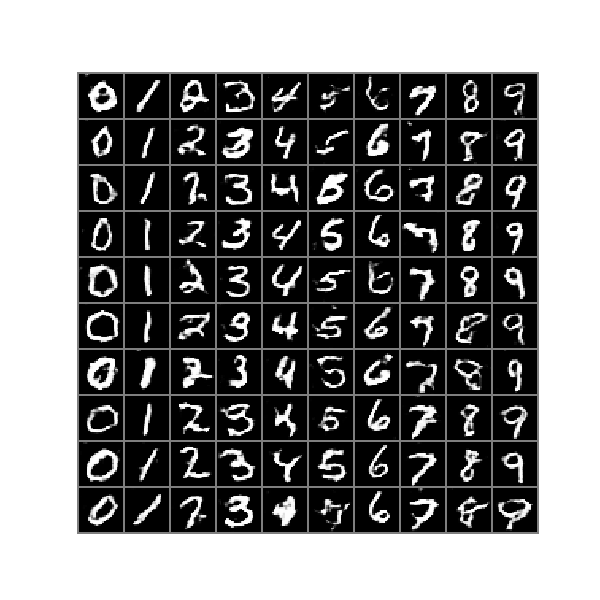

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | D(x): 0.571 | D(G(z)): 0.456 | Accuracy (real): 0.872 | Accuracy (fake): 0.766 | Epoch time:  6.045 |
Epoch 001: | D(x): 0.661 | D(G(z)): 0.351 | Accuracy (real): 0.914 | Accuracy (fake): 0.945 | Epoch time:  5.372 |
Epoch 002: | D(x): 0.692 | D(G(z)): 0.309 | Accuracy (real): 0.876 | Accuracy (fake): 0.915 | Epoch time:  5.629 |
Epoch 003: | D(x): 0.699 | D(G(z)): 0.300 | Accuracy (real): 0.859 | Accuracy (fake): 0.891 | Epoch time:  5.710 |
Epoch 004: | D(x): 0.672 | D(G(z)): 0.328 | Accuracy (real): 0.821 | Accuracy (fake): 0.853 | Epoch time:  5.416 |
Epoch 005: | D(x): 0.664 | D(G(z)): 0.333 | Accuracy (real): 0.804 | Accuracy (fake): 0.847 | Epoch time:  5.247 |
Epoch 006: | D(x): 0.680 | D(G(z)): 0.316 | Accuracy (real): 0.823 | Accuracy (fake): 0.853 | Epoch time:  5.081 |
Epoch 007: | D(x): 0.684 | D(G(z)): 0.312 | Accuracy (real): 0.820 | Accur

In [12]:
%matplotlib notebook

D           = 16
nEpochs     = 50
nIter       = nEpochs * len(oTrainDL)

oG          = Generator    (D).to(DEVICE)
oD          = Discriminator() .to(DEVICE)
oOptimG     = optim.Adam   (oG.parameters(), lr=0, betas=(0.2, 0.999))
oOptimD     = optim.Adam   (oD.parameters(), lr=0, betas=(0.2, 0.999))
oSchedulerG = OneCycleLR   (oOptimG, max_lr=5e-4, total_steps=nIter)
oSchedulerD = OneCycleLR   (oOptimD, max_lr=5e-4, total_steps=nIter)
lHistory    = TrainGAN     (oG, oD, oTrainDL, Loss, nEpochs, oOptimG, oOptimD, oSchedulerG, oSchedulerD, sModelName='CGAN')

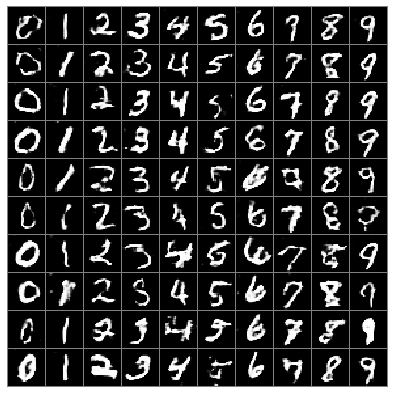

In [13]:
%matplotlib inline

oG.train(False)

mZ = torch.randn (100, oG.D, device=DEVICE)
vY = torch.arange(10,        device=DEVICE).repeat(10)
with torch.no_grad():
    mFake = (oG(mZ, vY).cpu() + 1) / 2
mGrid = torchvision.utils.make_grid(mFake, nrow=10, pad_value=1/2, padding=1)
mGrid = mGrid.permute(1,2,0)

fig, ax = plt.subplots(figsize=(7, 7))
ax.matshow(mGrid, cmap='gray')
ax.axis   ('off')
plt.show  ()